In [1]:
import random

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from utils.training.data_loading import get_line_to_spectro_class, csv_to_lines
from utils.training.models import resnet_model, custom_classif_model

2023-10-24 12:38:45.419042: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 12:38:45.455919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 12:38:45.455955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 12:38:45.455978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 12:38:45.461857: I tensorflow/core/platform/cpu_feature_g

In [2]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/classification/spectrogramsb"
SEED = 0
BATCH_SIZE = 64
EPOCHS = 50
CHECKPOINTS_DIR = "checkpoints_classif"

SIZE = (128, 128)  # number of pixels in the spectrograms
CHANNELS = 1  # 1 means grayscale 3 RGB

data_loader = get_line_to_spectro_class(SIZE, CHANNELS)
model = custom_classif_model()

2023-10-24 12:38:47.039580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 12:38:47.057164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 12:38:47.057313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
pos, neg = csv_to_lines(f"{ROOT_DIR}/dataset.csv", col_to_keep=0)
lines = pos + neg
print(len(lines), "files found")

random.Random(SEED).shuffle(lines)
train_lines = lines[int(0.2 * len(lines)):]
valid_lines = lines[:int(0.2 * len(lines))]

train_dataset = tf.data.Dataset.from_tensor_slices(train_lines)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_lines)

train_dataset = train_dataset.map(data_loader).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(data_loader).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

17126 files found


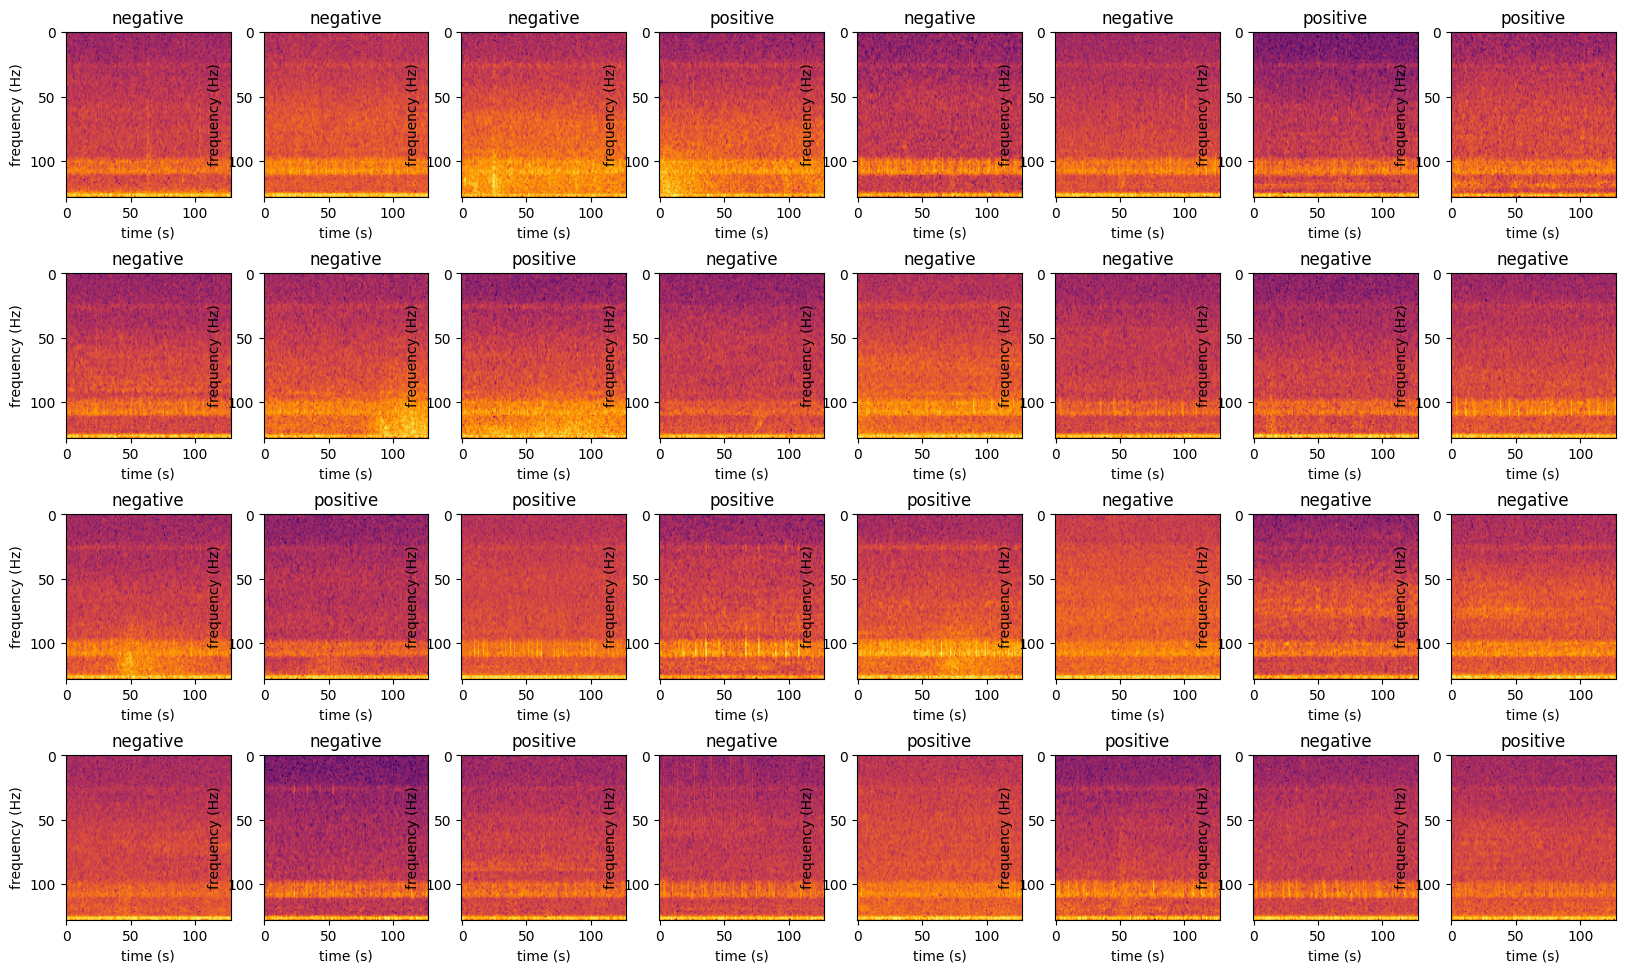

In [4]:
cols = 8
lines = 4
batch_number = 1  # number of the batch we want to inspect

to_show = cols * lines
plt.figure(figsize=(20, lines*3))
shown=0
for images, y in valid_dataset.take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines, cols, 1 + shown)
        plt.xlabel("time (s)")
        plt.ylabel("frequency (Hz)")
        plt.imshow(images[i].numpy()[:,:,0], cmap='inferno')
        label = "positive" if y[i]==1 else "negative"
        plt.title(label)

        shown += 1
plt.show()

In [5]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.losses.binary_crossentropy,
        metrics='Accuracy')

model.build((BATCH_SIZE, SIZE[0], SIZE[1], CHANNELS))

model.summary()

Model: "custom_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      1040      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      16400     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      16400     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)

In [6]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINTS_DIR + "/cp-{epoch:04d}.ckpt",
                                                     save_weights_only=True,
                                                     verbose=1)

In [7]:
model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        callbacks=[cp_callback]
    )

Epoch 1/50


2023-10-24 12:39:01.504425: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.06MiB (rounded to 4260096)requested by op custom_classifier/conv2d/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-24 12:39:01.504499: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-24 12:39:01.504515: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 82, Chunks in use: 82. 20.5KiB allocated for chunks. 20.5KiB in use in bin. 4.4KiB client-requested in use in bin.
2023-10-24 12:39:01.504524: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 10, Chunks in use: 9. 5.0KiB allocated for chunks. 4.5KiB in use in bin. 4.5KiB client-requested in use in bin.
2023-10-24 12:39:01.504533: I tensorf

ResourceExhaustedError: Graph execution error:

Detected at node custom_classifier/conv2d/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_70771/3142431990.py", line 1, in <module>

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[64,1,129,129] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node custom_classifier/conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4266]

In [ ]:
cols = 8
lines = 4
batch_number = 1

to_show = cols * lines
plt.figure(figsize=(20, lines*3))
shown=0
for images, y in valid_dataset.take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines, cols, 1 + shown)
        plt.xlabel("time (s)")
        plt.ylabel("frequency (Hz)")
        plt.imshow(images[i].numpy()[:,:,0], cmap='inferno')
        label = "positive" if y[i]==1 else "negative"
        predicted = model.predict(np.reshape(images[i], (1, SIZE[0], SIZE[1], CHANNELS)), verbose=False)[0]
        predicted_label = "positive" if predicted>=0.5 else "negative"
        plt.title(f"{predicted_label}/{label}")

        shown += 1
plt.show()